In [1]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import compress_pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

# from tools_pattern import get_eucledean_dist

script_n = 'distribution_123share_share_matrix_210512'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/' \
#                                    'mf_grc_model/input_graph_210407_all.gz')
         'gen_db/mf_grc/input_graph_210520_all_100_2.gz')

input_graph = compress_pickle.load(fname)
# GrCs are fully reconstructed and proofread from 90k to 150k

# 800+
z_min = 19800-5000
z_max = 29800+5000
x_min = 320*1000
x_max = 560*1000

# 400+
z_min = 19800
z_max = 29800
x_min = 320*1000
x_max = 560*1000

#270
z_min = 19800
z_max = 29800
x_min = (320+40)*1000
x_max = (560-40)*1000

#550
z_min = 19800-5000
z_max = 29800+5000
x_min = (320+40)*1000
x_max = (560-40)*1000

# #278
# z_min = 19800-5000
# z_max = 29800+5000
# x_min = (320+80)*1000
# x_max = (560-80)*1000

# n_randoms = 5
# replication_hist2 = defaultdict(int)
grc_ids = set()
# mf_ids = set()
# replicated_2shares = defaultdict(int)

def get_prob(in_graph):
    unique_count = True
    count_within_box = True
    overshare_pairs = defaultdict(int)
    processed = set()
    for grc_i_id in in_graph.grcs:
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        grc_ids.add(grc_i.soma_loc)
        rosettes_i = set([mf[1] for mf in grc_i.edges])
#         print(grc_i.edges);asdf
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
            if count_within_box:
                if x < x_min or x > x_max:
                    continue
                if z < z_min or z > z_max:
                    continue
            common_rosettes = set([mf[1] for mf in grc_j.edges])
            common_rosettes = common_rosettes & rosettes_i
            pair = tuple(sorted((grc_i.soma_loc, grc_j.soma_loc)))
            overshare_pairs[pair] = len(common_rosettes)
    return overshare_pairs

# input_observed = copy.deepcopy(input_graph)
# hist_data, n_grcs = get_prob(input_observed, count_within_box=True, return_counted=True)
overshare_data = get_prob(input_graph)
print(len(grc_ids))

# print(overshare_data)
# print(hist_data)
# n_grcs = len(input_graph.grcs)

550


In [2]:
grc_ids_list = list(grc_ids)
grc_ids_list = sorted(grc_ids_list, key=lambda x: x[0])
conv_mat = []
for i in grc_ids_list:
    row = []
    for j in grc_ids_list:
        row.append(overshare_data[tuple(sorted((i, j)))])
    conv_mat.append(row)

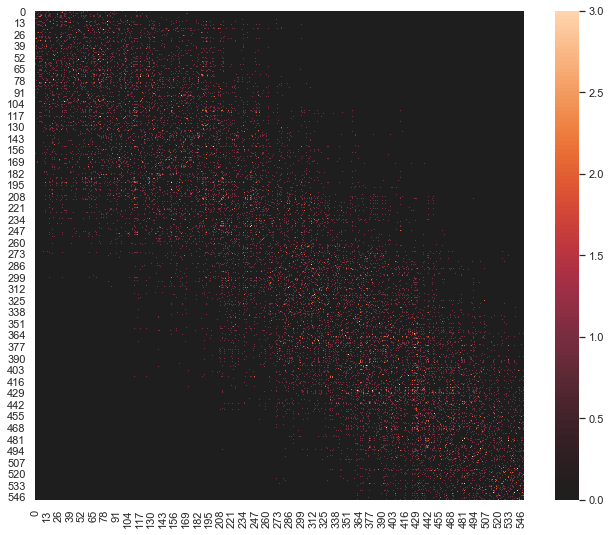

In [46]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(conv_mat,
            center=0,
            vmax=3,
            square=True,
           )

In [3]:
# random_datas = compress_pickle.load('mf_bouton_convergence_210519_random_gen_circle_22000_14800_34800_100.gz')
random_datas = compress_pickle.load(
#     'distribution_123share_bouton_convergence_210512_random_dist_400000_480000_14800_34800_100.gz'
    'distribution_123share_bouton_convergence_210512_random_dist_360000_520000_14800_34800_100.gz'
)
# calculate means and std
random_data_list = defaultdict(list)
for rand_data in random_datas:
    for pair in itertools.combinations(grc_ids_list, 2):
        pair = tuple(sorted(pair))
        random_data_list[pair].append(rand_data[pair])

import statistics
random_means_mat = []
random_std_mat = []
z_mat = []
for i in grc_ids_list:
    mean_row = []
    std_row = []
    row = []
    for j in grc_ids_list:
        if i == j:
            mean_row.append(0)
            std_row.append(0)
            row.append(0)
            continue
        l = random_data_list[tuple(sorted((i, j)))]
        d = overshare_data[tuple(sorted((i, j)))]
        mean, std = statistics.mean(l), statistics.stdev(l)
        mean_row.append(mean)
        std_row.append(std)
        if mean == 0 and d == 0:
            row.append(0)
            continue
        elif mean == 0 and std == 0:
            std = 0.01
            val = min((d-mean)/std, 3)
            row.append(val)
            continue
        row.append((d-mean)/std)
    random_means_mat.append(mean_row)
    random_std_mat.append(std_row)
    z_mat.append(row)

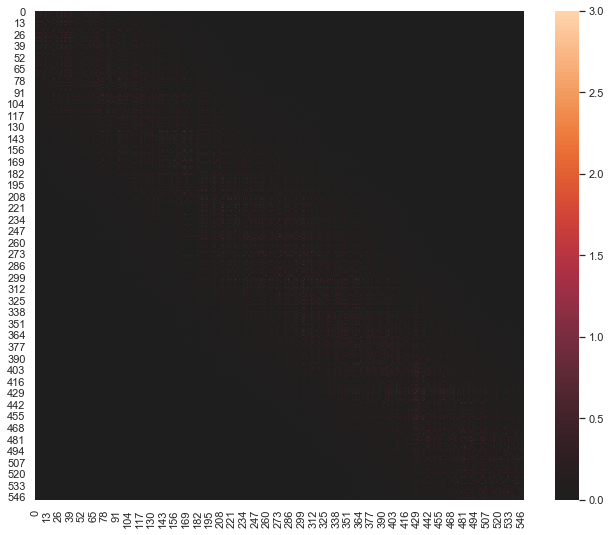

In [53]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(random_means_mat,
            vmax=3,
            center=0,
            square=True,
           )

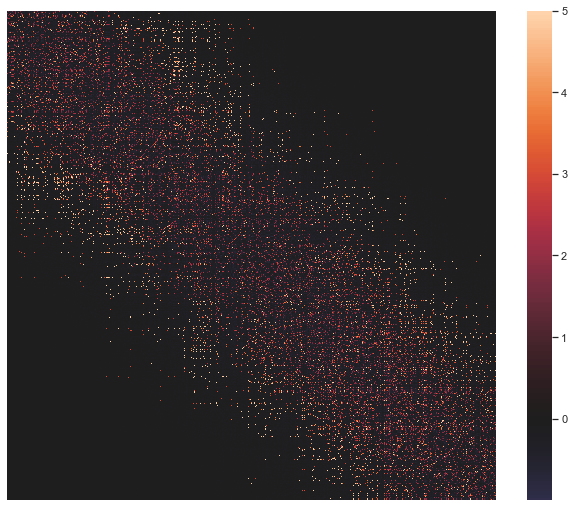

In [7]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(z_mat,
            vmax=5,
            center=0,
            square=True,
            xticklabels=[], yticklabels=[],
           )
# f.savefig(f'{script_n}_zscore.png', bbox_inches='tight', transparent=True)

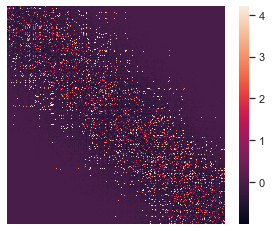

In [13]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            square=True,
            xticklabels=[], yticklabels=[],
           )
f.savefig(f'{script_n}_zscore_small.png', bbox_inches='tight', transparent=True)

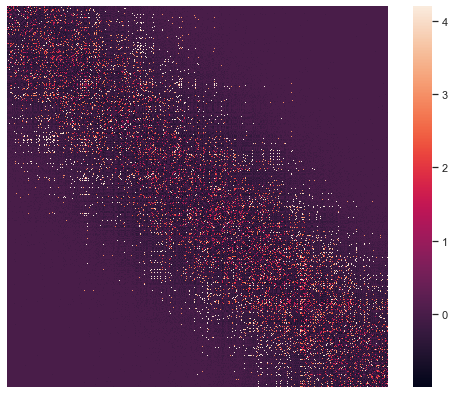

In [17]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            square=True,
            xticklabels=[], yticklabels=[],
           )
f.savefig(f'{script_n}_zscore_med.png', bbox_inches='tight', transparent=True)

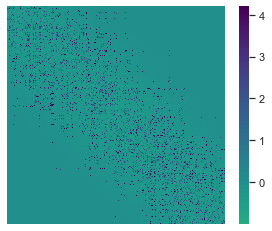

In [21]:
# f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots(figsize=(5, 4))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='viridis_r'
sns.heatmap(z_mat,
            vmax=4.2,
            center=0,
            square=True,
            xticklabels=[], yticklabels=[],
            cmap=cmap,
           )
# f.savefig(f'{script_n}_zscore.png', bbox_inches='tight', transparent=True)

In [32]:
import numpy as np
f = f'{script_n}_zmat.npz'
np.savez(f, z_mat)
import os
print(os.path.abspath(f))

/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/mf_grc_analysis/share_distribution/distribution_123share_share_matrix_210512_zmat.npz


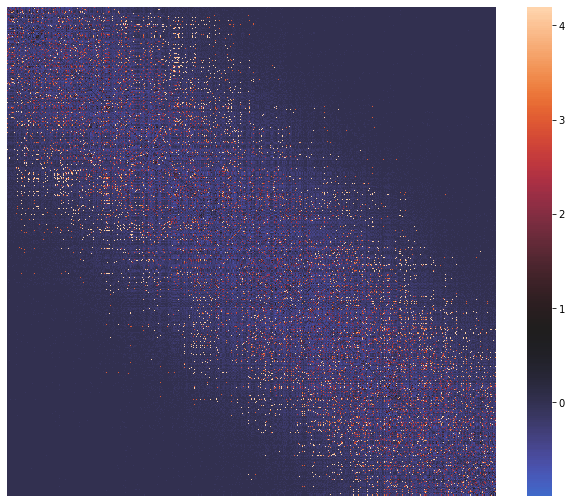

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
z_mat = np.load(f'/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/mf_grc_analysis/share_distribution/distribution_123share_share_matrix_210512_zmat.npz')['arr_0']
f, ax = plt.subplots(figsize=(11, 9))
# f, ax = plt.subplots(figsize=(5,4))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='viridis_r'
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            center=.75,
            square=True,
            xticklabels=[], yticklabels=[],
#             cmap=cmap,
           )
script_n = 'distribution_123share_share_matrix_210512'
# f.savefig(f'{script_n}_zscore.png', bbox_inches='tight', transparent=True)

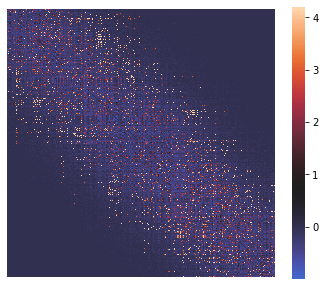

In [9]:
f, ax = plt.subplots(figsize=(6,5))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='viridis_r'
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            center=.75,
            square=True,
            xticklabels=[], yticklabels=[],
#             cmap=cmap,
           )
script_n = 'distribution_123share_share_matrix_210512'
f.savefig(f'{script_n}_zscore_small2.png', bbox_inches='tight', transparent=True)

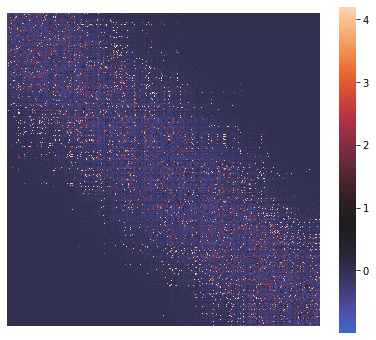

In [10]:
f, ax = plt.subplots(figsize=(7,6))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='viridis_r'
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            square=True,
            center=.75,
            xticklabels=[], yticklabels=[],
#             cmap=cmap,
           )
script_n = 'distribution_123share_share_matrix_210512'
f.savefig(f'{script_n}_zscore_small3.png', bbox_inches='tight', transparent=True)

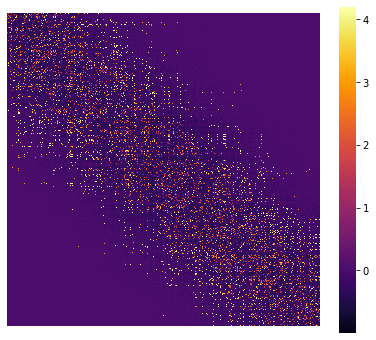

In [23]:
f, ax = plt.subplots(figsize=(7,6))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='inferno'
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            square=True,
            center=1.5,
            xticklabels=[], yticklabels=[],
            cmap=cmap,
           )
script_n = 'distribution_123share_share_matrix_210512'
f.savefig(f'{script_n}_zscore_inf_7x6.png', bbox_inches='tight', transparent=True)

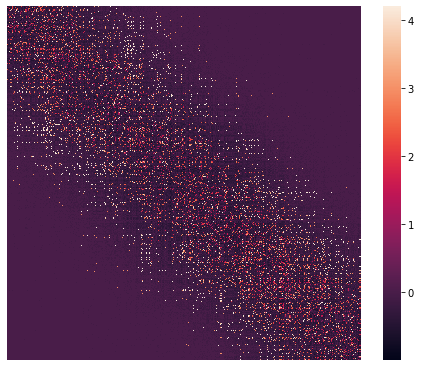

In [7]:
f, ax = plt.subplots(figsize=(8,6.5))
# cmap = sns.diverging_palette(250, 10, as_cmap=True, l=40, s=99, sep=1)
cmap='viridis_r'
sns.heatmap(z_mat,
            vmax=4.2,
#             center=0,
            square=True,
            xticklabels=[], yticklabels=[],
#             cmap=cmap,
           )
script_n = 'distribution_123share_share_matrix_210512'
f.savefig(f'{script_n}_zscore_small4.png', bbox_inches='tight', transparent=True)